### Configuring environment

#### Fetching  data

In [ ]:
!gdown https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=0f2b0ecb-93aa-4611-aca4-5616cb920558
To: /content/ninjacart_data.zip
100% 275M/275M [00:17<00:00, 16.2MB/s]


In [ ]:
datapath = "/content/ninjacart_data.zip"

In [ ]:
!unzip /content/ninjacart_data.zip

In [ ]:
!pip install torch torchvision

In [ ]:
!rm -rf /content/ninjacart_data/train/.ipynb_checkpoints
!rm -rf /content/ninjacart_data/test/.ipynb_checkpoints

#### Loading data

In [ ]:
from functools import reduce
import os

In [ ]:
TRAIN_DIR = "/content/ninjacart_data/train/"
TEST_DIR = "/content/ninjacart_data/test/"

In [ ]:
NUM_CLASSES = os.listdir(TRAIN_DIR).__len__()
NUM_CLASSES

4

checking the structure & characteristics of the data

In [ ]:
import os

def draw_tree(root_dir):
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print('{}{}/'.format(indent, os.path.basename(root)))

draw_tree('/content/ninjacart_data')

ninjacart_data/
    train/
        onion/
        indian market/
        tomato/
        potato/
    test/
        onion/
        indian market/
        tomato/
        potato/


In [ ]:
class_label_map = dict(enumerate(os.listdir(TRAIN_DIR)))

In [ ]:
def get_img_labels(_dir):
  task_files = {i: os.listdir(os.path.join(_dir, cls)) for i, cls in class_label_map.items()}
  return [(label, filename, cls) for cls, label in class_label_map.items() for filename in task_files[cls]]

In [ ]:
train_img_labels, test_img_labels = get_img_labels(TRAIN_DIR), get_img_labels(TEST_DIR)

In [ ]:
train_img_labels[0]

('onion', 'QUUN9IM7EN2U.jpg', 0)

#### Exploratory Data Analysis

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

In [ ]:
img_labels = list(map(lambda x: (x[0], x[1]), train_img_labels))

In [ ]:
df = pd.DataFrame(img_labels, columns=['labels', 'filenames'])
df.head()

,labels,filenames
0,onion,QUUN9IM7EN2U.jpg
1,onion,onion1151.jpeg
2,onion,U1QM5YBECIRZ.jpg
3,onion,P9AT7MJP8MD9.jpg
4,onion,onion11030 (1).jpeg


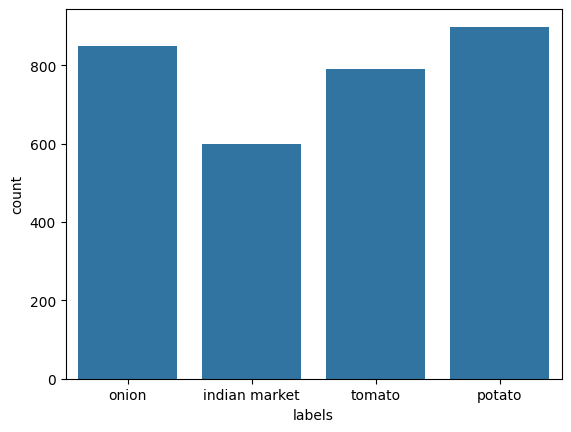

In [ ]:
sns.countplot(data=df, x="labels")
plt.show()

Plotting image dimensions

In [ ]:
df["full_paths"] = (TRAIN_DIR + df["labels"] + "/" + df["filenames"])

In [ ]:
df["height"] = df["full_paths"].apply(lambda x: Image.open(x).height)
df["width"] = df["full_paths"].apply(lambda x: Image.open(x).width)

In [ ]:
df.head()

,labels,filenames,full_paths,height,width
0,onion,QUUN9IM7EN2U.jpg,/content/ninjacart_data/train/onion/QUUN9IM7EN...,424,640
1,onion,onion1151.jpeg,/content/ninjacart_data/train/onion/onion1151....,168,300
2,onion,U1QM5YBECIRZ.jpg,/content/ninjacart_data/train/onion/U1QM5YBECI...,855,570
3,onion,P9AT7MJP8MD9.jpg,/content/ninjacart_data/train/onion/P9AT7MJP8M...,640,640
4,onion,onion11030 (1).jpeg,/content/ninjacart_data/train/onion/onion11030...,194,259


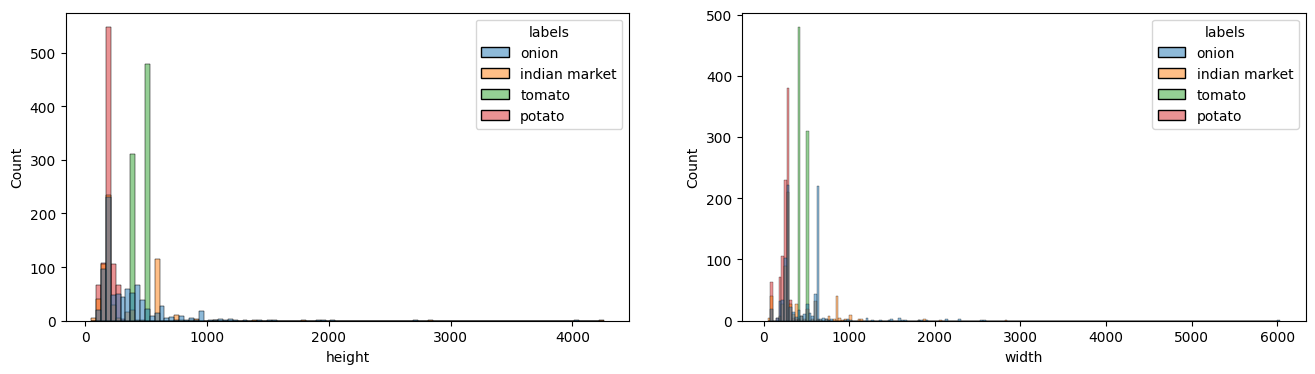

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x="height", hue="labels")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="width", hue="labels")

plt.show()


In [ ]:
from torchvision.transforms import v2

## Building CNN from scratch

In [ ]:
import torch
import os

### Creating Data Loader

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torch import float32

In [ ]:
class NinjacartDataset(Dataset):
  def __init__(self, img_dir, img_labels, transform=None, target_transform=None):
    super().__init__()
    self.img_labels = img_labels
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    foldername, filename, label = self.img_labels[idx]
    img_path = os.path.join(self.img_dir, foldername, filename)
    image = read_image(img_path)

    if self.transform:
      image = self.transform(image)

    if self.target_transform:
      label = self.target_transform(label)
    return image, label

In [ ]:
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToDtype(float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
train_data = NinjacartDataset(
    img_dir=TRAIN_DIR,
    img_labels=train_img_labels,
    transform=transform,
)

test_data = NinjacartDataset(
    img_dir=TEST_DIR,
    img_labels=test_img_labels,
    transform=transform,
)

#### Train validation split

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_data

In [ ]:
total_size = len(train_data)
total_size


3135

In [ ]:
train_split=0.8
train_size = int(train_split * total_size)
val_size = total_size - train_size

In [ ]:
random_seed = 42

train_dataset, val_dataset = random_split(
    train_data,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(random_seed)
)

In [ ]:
print(type(train_dataset))
print(type(val_dataset))

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [ ]:
len(val_dataset), len(train_dataset)

(627, 2508)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
im, cls = next(iter(train_dataloader))

print(im.shape)
print(cls.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
datasets = {
    "train": train_dataset,
    "val": val_dataset,
}

dataloaders = {
    "train": train_dataloader,
    "val": validation_dataloader,
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 2508, 'val': 627}


<Figure size 1600x1600 with 0 Axes>

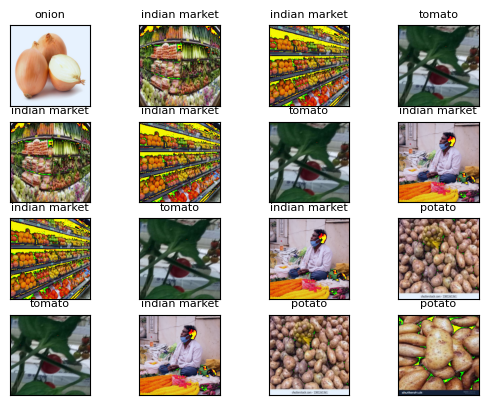

In [ ]:
plt.figure(figsize=(16, 16))

nrows = 4
ncols = 4

_, ax = plt.subplots(
    nrows,
    ncols,
    squeeze=True,
)

images = im[:16]
classes = cls[:16].tolist()
fontdict = {
    'fontsize': 8,
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center',
}

inverse_norm = v2.Compose([
    v2.Lambda(lambda img: img * 0.224),
    v2.Lambda(lambda img: img + 0.406),
])

# [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

for i in range(nrows):
    for j in range(ncols):
        tensor = im[i+j]
        inv_norm_tensor = inverse_norm(tensor)
        img = v2.ToPILImage()(inv_norm_tensor)

        ax[i][j].imshow(img)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        ax[i][j].set_title(class_label_map[cls[i+j].tolist()], loc='center', **fontdict)

plt.show()

### Utility functions

In [ ]:
import copy
import time

In [ ]:
from torch import set_grad_enabled, max, sum, device, cuda
from torch.nn import CrossEntropyLoss, Linear
from torch.optim import lr_scheduler, SGD, Adam
from tqdm import tqdm

In [ ]:
dvc = device("cuda" if cuda.is_available() else "cpu")

#### Callback

In [ ]:
def save_checkpoint(model, epoch, val_loss, best_val_loss, acc, best_acc, file_path='checkpoint.pth'):
  best_model_wts = copy.deepcopy(model.state_dict())

  if val_loss < best_val_loss:
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'val_loss': val_loss
    }, file_path)
    best_val_loss = val_loss
    best_model_wts = copy.deepcopy(model.state_dict())

  if acc > best_acc:
    best_acc = acc
    best_model_wts = copy.deepcopy(model.state_dict())

  return best_val_loss, best_acc, best_model_wts

#### Trainer

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    losses = {
        "train": [],
        "val": [],
    }
    accuracy = {
        "train": [],
        "val": [],
    }

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = (2**20 - 1)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('=' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            pbar = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]))

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(dvc), labels.to(dvc)
                optimizer.zero_grad()

                with set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(epoch_loss)
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)

            # pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            pbar.set_postfix({'loss': f'{running_loss/dataset_sizes[phase]:.4f}', 'acc': f'{100.*running_corrects/dataset_sizes[phase]:.2f}%'})

            if phase == "val":
                best_loss, best_acc, best_model_wts = save_checkpoint(model, epoch, loss, best_loss, epoch_acc, best_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses, accuracy

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    train_accs = [x.cpu().numpy() for x in train_accs]
    val_accs = [x.cpu().numpy() for x in val_accs]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


#### Evaluation and metrics

In [ ]:
from sklearn.metrics import confusion_matrix


def get_preds(model, dataloader):
  test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloader):
      inputs = inputs.to(dvc)
      labels = labels.to(dvc)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

  return preds, labels

def plot_confusion_matrix(y_true, y_pred, classes=None):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', square=True, ax=ax)

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Normalized Confusion Matrix')

    if classes is not None:
        ax.set_xticks(np.arange(len(classes)) + 0.5)
        ax.set_yticks(np.arange(len(classes)) + 0.5)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_yticklabels(classes, rotation=0)

    plt.tight_layout()
    plt.show()

In [ ]:
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
def visualize_predictions(model, num_images=6, device="cpu"):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(dvc)
            labels = labels.to(dvc)

            outputs = model(inputs)
            _, preds = max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(preds[j])
                ax.set_title(f'predicted: {labels_txt[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

### Vanilla CNN


In [ ]:
from torch import nn, flatten

In [ ]:
class VanillaCNN(nn.Module):
  def __init__(self):
    super(VanillaCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding="same")
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding="same")
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding="same")
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding="same")
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding="same")

    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = nn.Linear(in_features=512*7*7, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=4)

  def forward(self, x):
    x = self.maxpool(self.relu(self.conv1(x)))
    x = self.maxpool(self.relu(self.conv2(x)))
    x = self.maxpool(self.relu(self.conv3(x)))
    x = self.maxpool(self.relu(self.conv4(x)))
    x = self.maxpool(self.relu(self.conv5(x)))

    x = flatten(x, 1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)

    return x

In [ ]:
from torchsummary import summary

In [ ]:
net = VanillaCNN().to(dvc)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       1,180,160
             ReLU-14          [-1, 512,

In [ ]:
model, loss, accuracy = train_model(
    net,
    criterion,
    optimizer,
    exp_lr_scheduler,
    num_epochs=5,
)

Epoch 0/4


  0%|          | 0/79 [00:20<?, ?it/s, loss=0.1493, acc=94.22%]

0.14933102930846967






  0%|          | 0/79 [00:20<?, ?it/s, loss=0.1493, acc=94.22%]




  0%|          | 0/20 [00:07<?, ?it/s, loss=0.3775, acc=86.92%]

0.37753945237331604

Epoch 1/4


  0%|          | 0/79 [00:20<?, ?it/s, loss=0.1418, acc=94.58%]

0.1417619495562009






  0%|          | 0/79 [00:20<?, ?it/s, loss=0.1418, acc=94.58%]




  0%|          | 0/20 [00:04<?, ?it/s, loss=0.3605, acc=88.04%]

0.3605360160604048

Epoch 2/4


  0%|          | 0/79 [00:20<?, ?it/s, loss=0.1293, acc=95.33%]

0.12931632614461333






  0%|          | 0/79 [00:20<?, ?it/s, loss=0.1293, acc=95.33%]




  0%|          | 0/20 [00:04<?, ?it/s, loss=0.3899, acc=87.88%]

0.38988747142338487

Epoch 3/4


  0%|          | 0/79 [00:21<?, ?it/s, loss=0.1219, acc=95.26%]

0.12191273538214548






  0%|          | 0/79 [00:21<?, ?it/s, loss=0.1219, acc=95.26%]




  0%|          | 0/20 [00:07<?, ?it/s, loss=0.3874, acc=87.40%]

0.38737816331489233

Epoch 4/4


  0%|          | 0/79 [00:21<?, ?it/s, loss=0.1166, acc=95.69%]

0.11656060344294498






  0%|          | 0/79 [00:21<?, ?it/s, loss=0.1166, acc=95.69%]




  0%|          | 0/20 [00:04<?, ?it/s, loss=0.3990, acc=87.24%]

0.39904984047538355

Training complete in 2m 14s
Best val Acc: 0.880383


  0%|          | 0/20 [07:26<?, ?it/s, loss=0.3575, acc=86.92%]


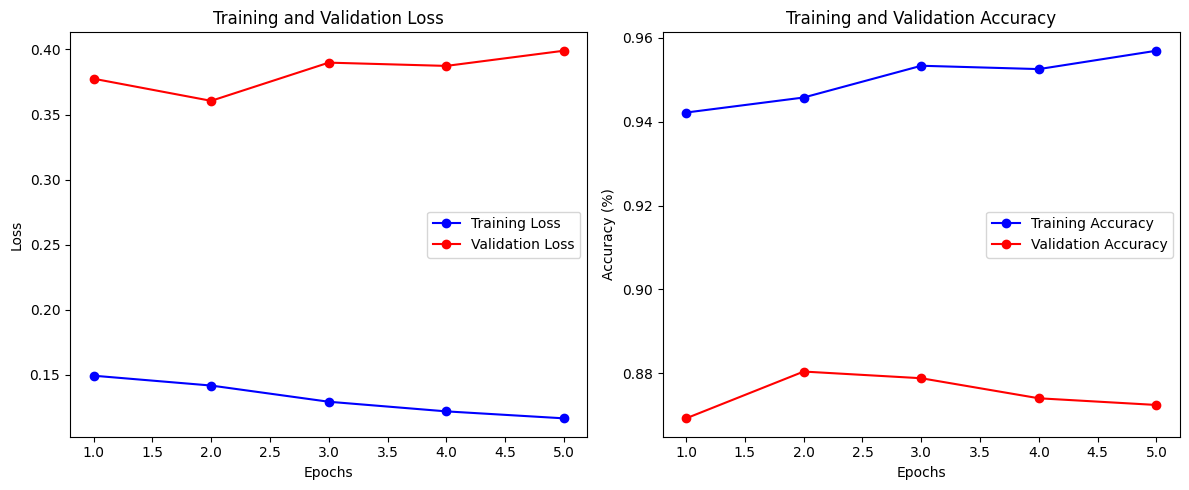

In [ ]:
plot_metrics(loss["train"], loss["val"], accuracy["train"], accuracy["val"])

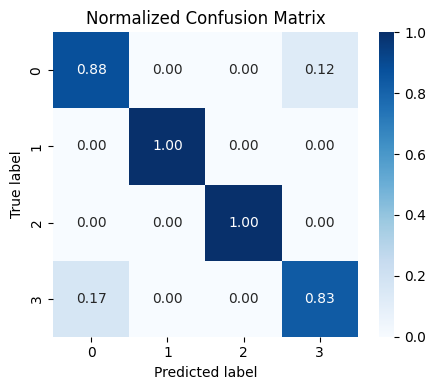

In [ ]:
y_pred, y_true = get_preds(model, test_dataloader)
plot_confusion_matrix(y_true.cpu(), y_pred.cpu(), classes=None)

### CNN with GAP

In [ ]:
class VanillaCNNGAP(nn.Module):
  def __init__(self):
    super(VanillaCNNGAP, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding="same")
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding="same")
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding="same")
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding="same")
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding="same")

    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.gap = nn.AdaptiveAvgPool2d((1, 1))

    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=NUM_CLASSES)

  def forward(self, x):
    x = self.maxpool(self.relu(self.conv1(x)))
    x = self.maxpool(self.relu(self.conv2(x)))
    x = self.maxpool(self.relu(self.conv3(x)))
    x = self.maxpool(self.relu(self.conv4(x)))
    x = self.maxpool(self.relu(self.conv5(x)))

    x = self.gap(x)
    x = x.view(x.size(0), -1)
    x = self.fc2(self.relu(self.fc1(x)))

    return x

In [ ]:
net = VanillaCNNGAP().to(dvc)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, loss, accuracy = train_model(
    net,
    criterion,
    optimizer,
    exp_lr_scheduler,
    num_epochs=5,
)

Epoch 0/4




  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:22<?, ?it/s, loss=1.0426, acc=50.92%]

1.0425783207542019





  0%|          | 0/79 [00:22<?, ?it/s, loss=1.0426, acc=50.92%]



  0%|          | 0/20 [00:06<?, ?it/s, loss=0.7313, acc=65.23%]

0.7313136664684119

Epoch 1/4




  0%|          | 0/20 [00:06<?, ?it/s, loss=0.7313, acc=65.23%]


  0%|          | 0/79 [00:20<?, ?it/s, loss=0.6270, acc=73.60%]

0.6269776345345012





  0%|          | 0/79 [00:20<?, ?it/s, loss=0.6270, acc=73.60%]



  0%|          | 0/20 [00:04<?, ?it/s, loss=0.7016, acc=75.28%]

0.7015849094261584

Epoch 2/4




  0%|          | 0/20 [00:04<?, ?it/s, loss=0.7016, acc=75.28%]


  0%|          | 0/79 [00:19<?, ?it/s, loss=0.5491, acc=78.67%]

0.5490772225544973





  0%|          | 0/79 [00:19<?, ?it/s, loss=0.5491, acc=78.67%]



  0%|          | 0/20 [00:06<?, ?it/s, loss=0.5309, acc=80.38%]

0.5309336106552842

Epoch 3/4




  0%|          | 0/20 [00:06<?, ?it/s, loss=0.5309, acc=80.38%]


  0%|          | 0/79 [00:19<?, ?it/s, loss=0.4942, acc=79.43%]

0.49416768196762273





  0%|          | 0/79 [00:19<?, ?it/s, loss=0.4942, acc=79.43%]



  0%|          | 0/20 [00:05<?, ?it/s, loss=0.5108, acc=79.74%]

0.5108352467013698

Epoch 4/4




  0%|          | 0/20 [00:05<?, ?it/s, loss=0.5108, acc=79.74%]


  0%|          | 0/79 [00:21<?, ?it/s, loss=0.4538, acc=83.01%]

0.4538492629782815





  0%|          | 0/79 [00:21<?, ?it/s, loss=0.4538, acc=83.01%]



  0%|          | 0/20 [00:04<?, ?it/s, loss=0.4788, acc=82.93%]

0.4788329757191538

Training complete in 2m 11s
Best val Acc: 0.829346


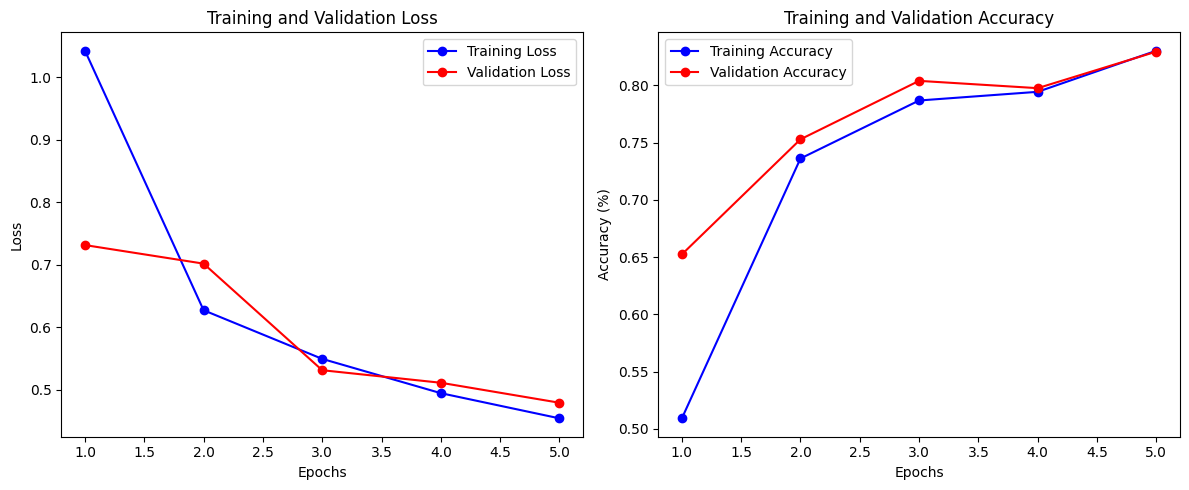

In [ ]:
plot_metrics(loss["train"], loss["val"], accuracy["train"], accuracy["val"])

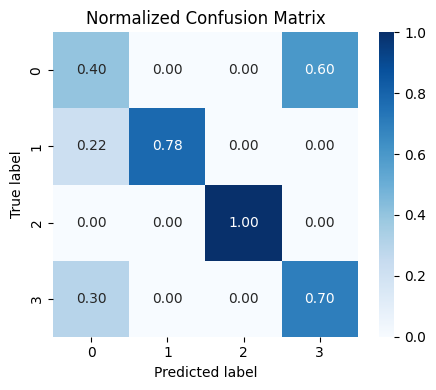

In [ ]:
y_pred, y_true = get_preds(model, test_dataloader)
plot_confusion_matrix(y_true.cpu(), y_pred.cpu(), classes=None)

### CNN with BatchNorm and Dropout

In [ ]:
class ModifiedCNN(nn.Module):
  def __init__(self):
    super(ModifiedCNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding="same")
    self.batch_norm_1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding="same")
    self.batch_norm_2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding="same")
    self.batch_norm_3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding="same")
    self.batch_norm_4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding="same")
    self.batch_norm_5 = nn.BatchNorm2d(512)
    self.conv_dropout = nn.Dropout2d(0.2)
    self.fc_dropout = nn.Dropout(0.5)

    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = nn.Linear(in_features=512*7*7, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=4)

    self.batch_norm = nn.BatchNorm2d

  def forward(self, x):
    x = self.batch_norm_1(self.conv1(x))
    x = self.conv_dropout(self.maxpool(self.relu(x)))
    x = self.batch_norm_2(self.conv2(x))
    x = self.conv_dropout(self.maxpool(self.relu(x)))
    x = self.batch_norm_3(self.conv3(x))
    x = self.conv_dropout(self.maxpool(self.relu(x)))
    x = self.batch_norm_4(self.conv4(x))
    x = self.conv_dropout(self.maxpool(self.relu(x)))
    x = self.batch_norm_5(self.conv5(x))
    x = self.conv_dropout(self.maxpool(self.relu(x)))

    x = flatten(x, 1)
    x = self.relu(self.fc1(x))
    x = self.fc_dropout(x)
    x = self.fc2(x)

    return x

In [ ]:
net = ModifiedCNN().to(dvc)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, loss, accuracy = train_model(
    net,
    criterion,
    optimizer,
    exp_lr_scheduler,
    num_epochs=5,
)

Epoch 0/3




  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:22<?, ?it/s, loss=1.4139, acc=60.25%]

1.4139455509337893





  0%|          | 0/79 [00:22<?, ?it/s, loss=1.4139, acc=60.25%]



  0%|          | 0/20 [00:06<?, ?it/s, loss=0.5942, acc=74.00%]

0.5941895180912109

Epoch 1/3




  0%|          | 0/20 [00:06<?, ?it/s, loss=0.5942, acc=74.00%]


  0%|          | 0/79 [00:21<?, ?it/s, loss=0.7472, acc=71.57%]

0.7471516599115192





  0%|          | 0/79 [00:21<?, ?it/s, loss=0.7472, acc=71.57%]



  0%|          | 0/20 [00:07<?, ?it/s, loss=0.5654, acc=74.96%]

0.5654485905379579

Epoch 2/3




  0%|          | 0/20 [00:07<?, ?it/s, loss=0.5654, acc=74.96%]


  0%|          | 0/79 [00:25<?, ?it/s, loss=0.6998, acc=73.41%]

0.6998396988310502





  0%|          | 0/79 [00:25<?, ?it/s, loss=0.6998, acc=73.41%]



  0%|          | 0/20 [00:05<?, ?it/s, loss=0.5374, acc=79.74%]

0.5374335470762359

Epoch 3/3




  0%|          | 0/20 [00:05<?, ?it/s, loss=0.5374, acc=79.74%]


  0%|          | 0/79 [00:22<?, ?it/s, loss=0.6772, acc=72.33%]

0.677233901320462





  0%|          | 0/79 [00:23<?, ?it/s, loss=0.6772, acc=72.33%]



  0%|          | 0/20 [00:04<?, ?it/s, loss=0.4928, acc=82.14%]

0.4927608315168956

Training complete in 1m 57s
Best val Acc: 0.821372


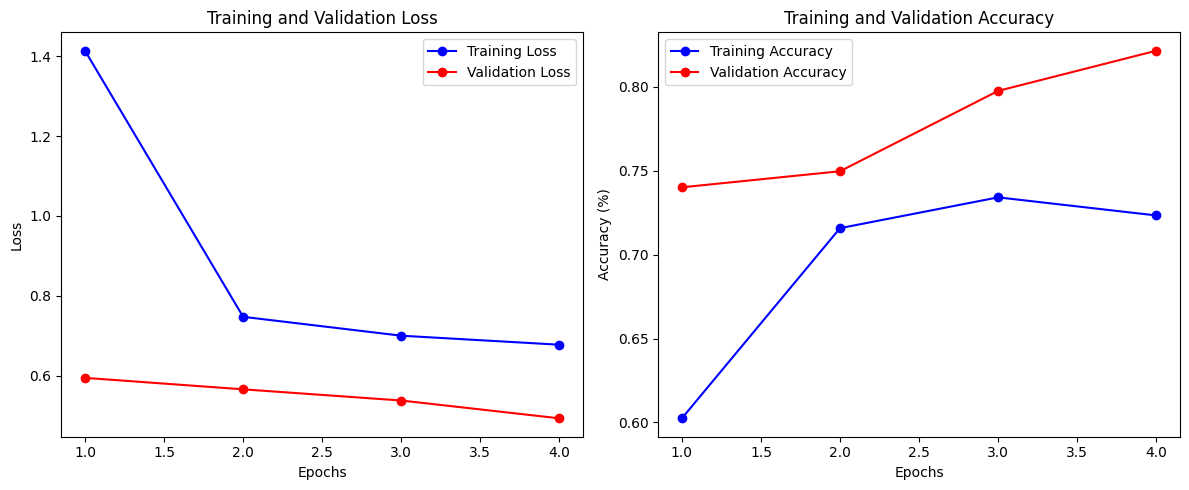

In [ ]:
plot_metrics(loss["train"], loss["val"], accuracy["train"], accuracy["val"])

In [ ]:
y_pred, y_true = get_preds(model, test_dataloader)
plot_confusion_matrix(y_true.cpu(), y_pred.cpu(), classes=None)

### Finetuning pretrained weights

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
model_ft = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [ ]:
num_features = model_ft.fc.in_features
num_features

2048

In [ ]:
model_ft.fc = Linear(num_features, 4)
model_ft = model_ft.to("cuda")

criterion = CrossEntropyLoss()
optimizer_ft = SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_pt, loss, accuracy = train_model(
    model_ft,
    criterion,
    optimizer,
    exp_lr_scheduler,
    num_epochs=4,
)

Epoch 0/3


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
  0%|          | 0/79 [00:30<?, ?it/s, loss=1.4274, acc=21.01%]

1.4274139235084327



  0%|          | 0/79 [00:30<?, ?it/s, loss=1.4274, acc=21.01%]

  0%|          | 0/20 [00:04<?, ?it/s, loss=1.4304, acc=21.69%]

1.4303783252478786

Epoch 1/3


  0%|          | 0/79 [00:32<?, ?it/s, loss=1.4252, acc=21.37%]

1.4251778798810604



  0%|          | 0/79 [00:32<?, ?it/s, loss=1.4252, acc=21.37%]

  0%|          | 0/20 [00:04<?, ?it/s, loss=1.4300, acc=22.49%]

1.4299582858975424

Epoch 2/3


  0%|          | 0/79 [00:36<?, ?it/s, loss=1.4276, acc=20.45%]

1.4276003558099555



  0%|          | 0/79 [00:36<?, ?it/s, loss=1.4276, acc=20.45%]

  0%|          | 0/20 [00:06<?, ?it/s, loss=1.4283, acc=22.17%]

1.4282951366388057

Epoch 3/3


  0%|          | 0/79 [00:31<?, ?it/s, loss=1.4285, acc=22.09%]

1.4284517835391957



  0%|          | 0/79 [00:31<?, ?it/s, loss=1.4285, acc=22.09%]

  0%|          | 0/20 [00:08<?, ?it/s, loss=1.4277, acc=22.01%]

1.427652138081844

Training complete in 2m 38s
Best val Acc: 0.224880


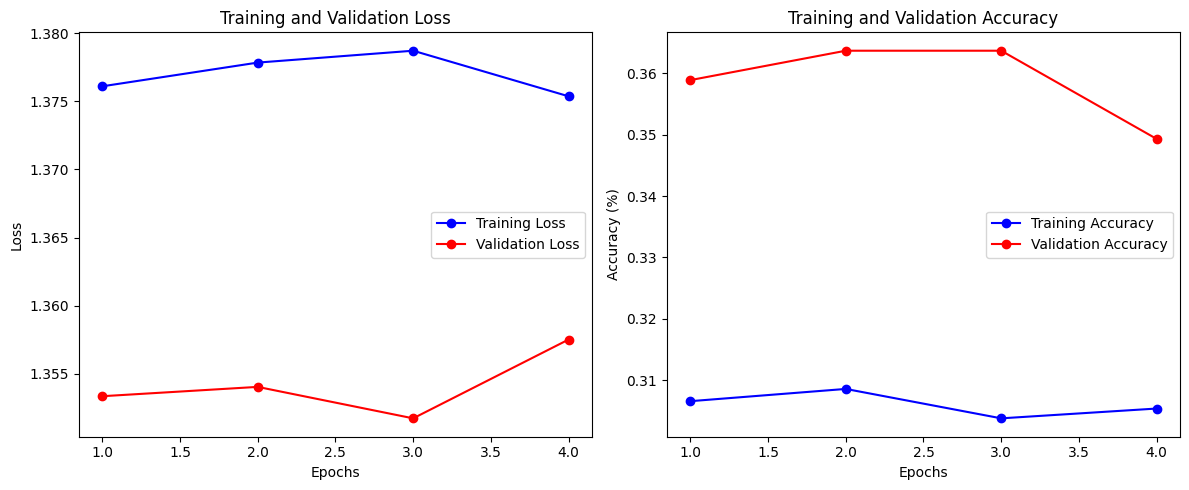

In [ ]:
plot_metrics(loss["train"], loss["val"], accuracy["train"], accuracy["val"])

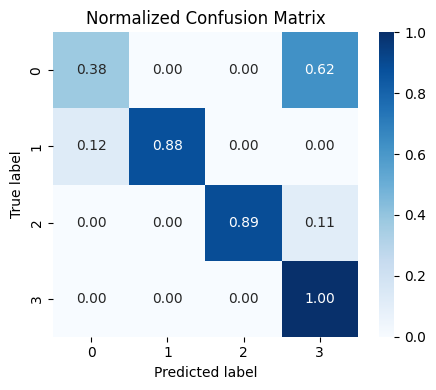

In [ ]:
y_pred, y_true = get_preds(test_dataloader)
plot_confusion_matrix(y_true.cpu(), y_pred.cpu(), classes=None)

## Summary and conclusion

This notebook explores different CNN architectures for image classification on a custom dataset.

We started by analyzing the data, visualizing distributions of image height and width, and creating a custom dataset class with appropriate transformations.

We then implemented several CNN models from scratch, including a basic CNN, a CNN with Global Average Pooling (GAP), and a CNN with Batch Normalization and Dropout.

Finally, we fine-tuned a pre-trained ResNet50 model for our specific task.


Through experimentation, we observed that:

* **Fine-tuning a pre-trained model generally yields the best performance.** ResNet50 demonstrated superior accuracy compared to models built from scratch.
* **GAP layers can be beneficial for reducing overfitting.** The CNN with GAP showed improved generalization compared to the basic CNN.
* **Adding Batch Normalization and Dropout can enhance model stability and prevent overfitting.** The modified CNN with these layers showed better performance than the basic CNN.

This project highlights the importance of data analysis, model architecture selection, and hyperparameter tuning for effective image classification.


### Random stuff

In [ ]:
512 * 49

25088

In [ ]:
16384 / 32

512.0

In [ ]:
1568 / 32

In [ ]:
import torch

In [ ]:
a = torch.ones(size=[32, 512, 7, 7])

In [ ]:
a.view(-1, 512).shape

torch.Size([1568, 512])

In [ ]:
a.view(-1, 32).shape

torch.Size([25088, 32])

In [ ]:
torch.flatten(a, 1).shape

torch.Size([32, 25088])

In [ ]:
a.reshape(a.size(0), -1).shape

torch.Size([32, 25088])

In [ ]:
a.view(a.size(0), -1).shape

torch.Size([32, 25088])

## Exploring `torch.nn.Module` class

In [ ]:
import torch
import torch.nn as nn

In [ ]:
import traceback

### `torch.nn.Module.child`

In [ ]:
class ChildModule(nn.Module):
    def __init__(self):
        super(ChildModule, self).__init__()
        self.linear = nn.Linear(10, 5)

    def forward(self, x):
        return self.linear(x)

class ParentModule(nn.Module):
    def __init__(self):
        super(ParentModule, self).__init__()
        self.child = ChildModule()
        self.other_layer = nn.Linear(5, 2)

    def forward(self, x):
        x = self.child(x)
        x = self.other_layer(x)
        return x

# Example usage
parent_model = ParentModule()
input_tensor = torch.randn(1, 10)
output_tensor = parent_model(input_tensor)
print(output_tensor)

tensor([[-0.2508, -0.4733]], grad_fn=<AddmmBackward0>)


In [ ]:
def show_child_modules(child_iter):
  try:
    while True:
      print(next(child_iter))
  except StopIteration as se:
    print(traceback.format_exc())

In [ ]:
chitr_1 = parent_model.children()
show_child_modules(chitr_1)

ChildModule(
  (linear): Linear(in_features=10, out_features=5, bias=True)
)
Linear(in_features=5, out_features=2, bias=True)
Traceback (most recent call last):
  File "<ipython-input-14-e837353b86cb>", line 4, in show_child_modules
    print(next(child_iter))
StopIteration



In [ ]:
child_model = ChildModule()

In [ ]:
chitr_2 = child_model.children()
show_child_modules(chitr_2)

Linear(in_features=10, out_features=5, bias=True)
Traceback (most recent call last):
  File "<ipython-input-14-e837353b86cb>", line 4, in show_child_modules
    print(next(child_iter))
StopIteration



In [ ]:
child_model.add_module(name="activation", module=nn.ReLU())

In [ ]:
chitr_2 = child_model.children()
show_child_modules(chitr_2)

Linear(in_features=10, out_features=5, bias=True)
ReLU()
Traceback (most recent call last):
  File "<ipython-input-14-e837353b86cb>", line 4, in show_child_modules
    print(next(child_iter))
StopIteration



In [ ]:
parent_model

ParentModule(
  (child): ChildModule(
    (linear): Linear(in_features=10, out_features=5, bias=True)
  )
  (other_layer): Linear(in_features=5, out_features=2, bias=True)
)

`get_submodule`

In [ ]:
parent_model = ParentModule()
parent_model

ParentModule(
  (child): ChildModule(
    (linear): Linear(in_features=10, out_features=5, bias=True)
  )
  (other_layer): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
parent_model.get_submodule("child")

ChildModule(
  (linear): Linear(in_features=10, out_features=5, bias=True)
)

In [ ]:
parent_model.get_submodule("other_layer")

Linear(in_features=5, out_features=2, bias=True)